In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import torchvision as tv
import pandas as pd
import numpy as np
import time

In [2]:
BATCH_SIZE=256

In [3]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [4]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

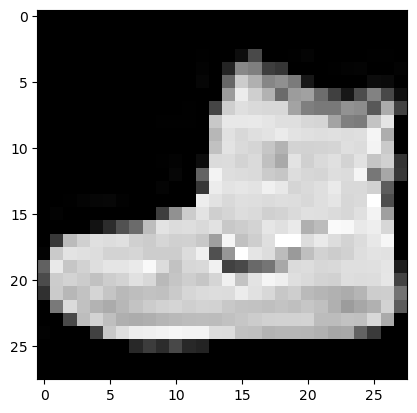

In [5]:
plt.imshow(train_dataset[0][0].numpy().reshape(28,28), cmap='gray');

In [6]:
#try model from lectures
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5, padding=0),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(2, stride=2),
    torch.nn.Conv2d(6, 16, kernel_size=5),
    torch.nn.AvgPool2d(2, stride=2),
    torch.nn.Conv2d(16, 120, kernel_size=4),
    torch.nn.Flatten(),
    torch.nn.Linear(120, 84),
    torch.nn.Tanh(),
    torch.nn.Linear(84, 10)
)

In [7]:

from torchsummary import summary

summary(model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              Tanh-2            [-1, 6, 24, 24]               0
         AvgPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
         AvgPool2d-5             [-1, 16, 4, 4]               0
            Conv2d-6            [-1, 120, 1, 1]          30,840
           Flatten-7                  [-1, 120]               0
            Linear-8                   [-1, 84]          10,164
              Tanh-9                   [-1, 84]               0
           Linear-10                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.17
Estimated Tot

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
model = model.to(device)

In [10]:
def train(net, train_iter, test_iter, optimizer, num_epochs, device):
    loss = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
    
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
    
        test_acc = evaluate_accuracy(test_iter, net, device)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [11]:
def evaluate_accuracy(data_iter, net, device):
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [12]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0033, train acc 0.686, test acc 0.757, time 17.1 sec
epoch 2, loss 0.0022, train acc 0.793, test acc 0.795, time 10.0 sec
epoch 3, loss 0.0019, train acc 0.818, test acc 0.813, time 8.8 sec
epoch 4, loss 0.0018, train acc 0.834, test acc 0.827, time 9.3 sec
epoch 5, loss 0.0017, train acc 0.844, test acc 0.840, time 10.7 sec


In [24]:
#try to add regularization
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5, padding=0),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(2, stride=2),
    torch.nn.Dropout(0.5),
    torch.nn.Conv2d(6, 16, kernel_size=5),
    torch.nn.AvgPool2d(2, stride=2),
    torch.nn.Conv2d(16, 120, kernel_size=4),
    torch.nn.Flatten(),
    torch.nn.BatchNorm1d(120),
    torch.nn.Linear(120, 84),
    torch.nn.Tanh(),
    torch.nn.Linear(84, 10)
)
model = model.to(device)

In [25]:
lr, num_epochs = 0.001, 20
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0028, train acc 0.752, test acc 0.788, time 10.2 sec
epoch 2, loss 0.0020, train acc 0.810, test acc 0.806, time 10.0 sec
epoch 3, loss 0.0019, train acc 0.825, test acc 0.824, time 10.8 sec
epoch 4, loss 0.0018, train acc 0.835, test acc 0.824, time 11.1 sec
epoch 5, loss 0.0017, train acc 0.840, test acc 0.827, time 8.9 sec
epoch 6, loss 0.0017, train acc 0.845, test acc 0.836, time 10.8 sec
epoch 7, loss 0.0016, train acc 0.849, test acc 0.837, time 9.6 sec
epoch 8, loss 0.0016, train acc 0.853, test acc 0.842, time 8.7 sec
epoch 9, loss 0.0016, train acc 0.856, test acc 0.841, time 9.2 sec
epoch 10, loss 0.0015, train acc 0.856, test acc 0.840, time 9.4 sec
epoch 11, loss 0.0015, train acc 0.860, test acc 0.845, time 9.0 sec
epoch 12, loss 0.0015, train acc 0.861, test acc 0.846, time 9.9 sec
epoch 13, loss 0.0015, train acc 0.862, test acc 0.847, time 9.0 sec
epoch 14, loss 0.0015, train acc 0.865, test acc 0.850, time 8.9 sec
epoch 15, loss 0.0014, train acc 0.866

Accuracy is low, continue experimenting...

In [31]:
#try to add regularization
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 10, kernel_size=5, padding=0),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(2, stride=2),
    torch.nn.Conv2d(10, 20, kernel_size=5),
    torch.nn.Dropout(0.5),
    torch.nn.AvgPool2d(2, stride=2),
    torch.nn.Conv2d(20, 200, kernel_size=4),
    torch.nn.Flatten(),
    torch.nn.Linear(200, 100),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(100),
    torch.nn.Linear(100, 10)
)
summary(model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
              Tanh-2           [-1, 10, 24, 24]               0
         AvgPool2d-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
           Dropout-5             [-1, 20, 8, 8]               0
         AvgPool2d-6             [-1, 20, 4, 4]               0
            Conv2d-7            [-1, 200, 1, 1]          64,200
           Flatten-8                  [-1, 200]               0
            Linear-9                  [-1, 100]          20,100
             Tanh-10                  [-1, 100]               0
      BatchNorm1d-11                  [-1, 100]             200
           Linear-12                   [-1, 10]           1,010
Total params: 90,790
Trainable params: 90,790
Non-trainable params: 0
---------------------------------

In [32]:
model = model.to(device)

In [33]:
lr, num_epochs = 0.001, 20
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0026, train acc 0.762, test acc 0.780, time 10.4 sec
epoch 2, loss 0.0021, train acc 0.803, test acc 0.791, time 10.3 sec
epoch 3, loss 0.0020, train acc 0.815, test acc 0.802, time 10.3 sec
epoch 4, loss 0.0019, train acc 0.822, test acc 0.813, time 9.1 sec
epoch 5, loss 0.0018, train acc 0.830, test acc 0.822, time 10.0 sec
epoch 6, loss 0.0017, train acc 0.840, test acc 0.832, time 10.3 sec
epoch 7, loss 0.0016, train acc 0.847, test acc 0.839, time 10.0 sec
epoch 8, loss 0.0016, train acc 0.853, test acc 0.845, time 9.2 sec
epoch 9, loss 0.0015, train acc 0.856, test acc 0.847, time 10.1 sec
epoch 10, loss 0.0015, train acc 0.863, test acc 0.846, time 10.4 sec
epoch 11, loss 0.0014, train acc 0.865, test acc 0.852, time 10.5 sec
epoch 12, loss 0.0014, train acc 0.869, test acc 0.859, time 9.2 sec
epoch 13, loss 0.0014, train acc 0.871, test acc 0.859, time 9.3 sec
epoch 14, loss 0.0013, train acc 0.875, test acc 0.863, time 10.0 sec
epoch 15, loss 0.0013, train acc 

Results are better, but seems like model has been retrained, try add more regularization layers

In [34]:
#try to add regularization
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 10, kernel_size=5, padding=0),
    torch.nn.Tanh(),
    torch.nn.Dropout(0.3),
    torch.nn.AvgPool2d(2, stride=2),
    torch.nn.Conv2d(10, 20, kernel_size=5),
    torch.nn.Dropout(0.3),
    torch.nn.AvgPool2d(2, stride=2),
    torch.nn.Conv2d(20, 200, kernel_size=4),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(200, 100),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(100),
    torch.nn.Linear(100, 10)
)
summary(model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
              Tanh-2           [-1, 10, 24, 24]               0
           Dropout-3           [-1, 10, 24, 24]               0
         AvgPool2d-4           [-1, 10, 12, 12]               0
            Conv2d-5             [-1, 20, 8, 8]           5,020
           Dropout-6             [-1, 20, 8, 8]               0
         AvgPool2d-7             [-1, 20, 4, 4]               0
            Conv2d-8            [-1, 200, 1, 1]          64,200
           Flatten-9                  [-1, 200]               0
          Dropout-10                  [-1, 200]               0
           Linear-11                  [-1, 100]          20,100
             Tanh-12                  [-1, 100]               0
      BatchNorm1d-13                  [-1, 100]             200
           Linear-14                   

In [35]:
model = model.to(device)

In [36]:
lr, num_epochs = 0.001, 50
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0027, train acc 0.751, test acc 0.779, time 10.1 sec
epoch 2, loss 0.0021, train acc 0.801, test acc 0.793, time 10.1 sec
epoch 3, loss 0.0020, train acc 0.813, test acc 0.807, time 8.9 sec
epoch 4, loss 0.0019, train acc 0.821, test acc 0.808, time 9.7 sec
epoch 5, loss 0.0018, train acc 0.830, test acc 0.821, time 9.6 sec
epoch 6, loss 0.0018, train acc 0.834, test acc 0.827, time 8.6 sec
epoch 7, loss 0.0017, train acc 0.840, test acc 0.834, time 10.0 sec
epoch 8, loss 0.0016, train acc 0.848, test acc 0.836, time 9.1 sec
epoch 9, loss 0.0016, train acc 0.851, test acc 0.845, time 9.3 sec
epoch 10, loss 0.0015, train acc 0.856, test acc 0.845, time 8.9 sec
epoch 11, loss 0.0015, train acc 0.860, test acc 0.843, time 8.8 sec
epoch 12, loss 0.0015, train acc 0.861, test acc 0.849, time 9.1 sec
epoch 13, loss 0.0015, train acc 0.863, test acc 0.853, time 9.4 sec
epoch 14, loss 0.0014, train acc 0.865, test acc 0.853, time 9.4 sec
epoch 15, loss 0.0014, train acc 0.868, 

overtrained...

In [40]:
#add missed tanh after convolution and max pooling
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 10, kernel_size=5, padding=0),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(2, stride=2),
    torch.nn.Conv2d(10, 20, kernel_size=5),
    torch.nn.Tanh(),
    torch.nn.Dropout(0.5),
    torch.nn.MaxPool2d(2, stride=2),
    torch.nn.Conv2d(20, 200, kernel_size=4),
    torch.nn.Tanh(),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(200, 100),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(100),
    torch.nn.Linear(100, 10)
)
summary(model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
              Tanh-2           [-1, 10, 24, 24]               0
         AvgPool2d-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
              Tanh-5             [-1, 20, 8, 8]               0
           Dropout-6             [-1, 20, 8, 8]               0
         MaxPool2d-7             [-1, 20, 4, 4]               0
            Conv2d-8            [-1, 200, 1, 1]          64,200
              Tanh-9            [-1, 200, 1, 1]               0
          Flatten-10                  [-1, 200]               0
          Dropout-11                  [-1, 200]               0
           Linear-12                  [-1, 100]          20,100
             Tanh-13                  [-1, 100]               0
      BatchNorm1d-14                  [

In [41]:
model = model.to(device)

In [42]:
lr, num_epochs = 0.001, 50
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0026, train acc 0.758, test acc 0.799, time 9.5 sec
epoch 2, loss 0.0019, train acc 0.824, test acc 0.820, time 9.5 sec
epoch 3, loss 0.0017, train acc 0.839, test acc 0.830, time 9.5 sec
epoch 4, loss 0.0017, train acc 0.846, test acc 0.839, time 9.4 sec
epoch 5, loss 0.0016, train acc 0.851, test acc 0.843, time 9.2 sec
epoch 6, loss 0.0016, train acc 0.855, test acc 0.846, time 9.4 sec
epoch 7, loss 0.0015, train acc 0.858, test acc 0.851, time 9.3 sec
epoch 8, loss 0.0015, train acc 0.860, test acc 0.849, time 9.3 sec
epoch 9, loss 0.0015, train acc 0.863, test acc 0.854, time 9.2 sec
epoch 10, loss 0.0014, train acc 0.864, test acc 0.855, time 9.4 sec
epoch 11, loss 0.0014, train acc 0.866, test acc 0.860, time 9.3 sec
epoch 12, loss 0.0014, train acc 0.868, test acc 0.858, time 9.2 sec
epoch 13, loss 0.0014, train acc 0.870, test acc 0.860, time 9.2 sec
epoch 14, loss 0.0014, train acc 0.872, test acc 0.857, time 9.3 sec
epoch 15, loss 0.0013, train acc 0.873, tes

In [49]:
#remove max pooling and add more regularization
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 10, kernel_size=5, padding=0),
    torch.nn.AvgPool2d(2, stride=2),
    torch.nn.Dropout(0.5),
    torch.nn.Conv2d(10, 20, kernel_size=5),
    torch.nn.BatchNorm2d(20),
    torch.nn.AvgPool2d(2, stride=2),
    torch.nn.Conv2d(20, 200, kernel_size=4),
    torch.nn.Dropout(0.5),
    torch.nn.Tanh(),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(200, 100),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(100),
    torch.nn.Linear(100, 10)
)
summary(model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         AvgPool2d-2           [-1, 10, 12, 12]               0
           Dropout-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
       BatchNorm2d-5             [-1, 20, 8, 8]              40
         AvgPool2d-6             [-1, 20, 4, 4]               0
            Conv2d-7            [-1, 200, 1, 1]          64,200
           Dropout-8            [-1, 200, 1, 1]               0
              Tanh-9            [-1, 200, 1, 1]               0
          Flatten-10                  [-1, 200]               0
          Dropout-11                  [-1, 200]               0
           Linear-12                  [-1, 100]          20,100
             Tanh-13                  [-1, 100]               0
      BatchNorm1d-14                  [

In [50]:
model = model.to(device)

In [51]:
lr, num_epochs = 0.001, 50
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0031, train acc 0.708, test acc 0.757, time 9.4 sec
epoch 2, loss 0.0023, train acc 0.781, test acc 0.784, time 9.3 sec
epoch 3, loss 0.0022, train acc 0.796, test acc 0.785, time 9.3 sec
epoch 4, loss 0.0021, train acc 0.804, test acc 0.795, time 9.3 sec
epoch 5, loss 0.0020, train acc 0.812, test acc 0.802, time 9.2 sec
epoch 6, loss 0.0020, train acc 0.816, test acc 0.804, time 9.5 sec
epoch 7, loss 0.0019, train acc 0.820, test acc 0.809, time 9.2 sec
epoch 8, loss 0.0019, train acc 0.822, test acc 0.810, time 9.6 sec
epoch 9, loss 0.0019, train acc 0.828, test acc 0.811, time 9.0 sec
epoch 10, loss 0.0019, train acc 0.828, test acc 0.819, time 9.4 sec
epoch 11, loss 0.0018, train acc 0.829, test acc 0.818, time 9.6 sec
epoch 12, loss 0.0018, train acc 0.834, test acc 0.821, time 9.3 sec
epoch 13, loss 0.0018, train acc 0.832, test acc 0.823, time 9.2 sec
epoch 14, loss 0.0018, train acc 0.834, test acc 0.817, time 9.3 sec
epoch 15, loss 0.0018, train acc 0.836, tes

In [53]:
from torch import nn

try another architecture...

# AlexNet-like model

In [56]:
model = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(256, 384, kernel_size=4, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(9600, 4800),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4800, 2400),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2400, 10)
)
summary(model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 24, 24]           2,496
              ReLU-2           [-1, 96, 24, 24]               0
         MaxPool2d-3           [-1, 96, 12, 12]               0
            Conv2d-4          [-1, 256, 12, 12]         614,656
              ReLU-5          [-1, 256, 12, 12]               0
         MaxPool2d-6            [-1, 256, 6, 6]               0
            Conv2d-7            [-1, 384, 5, 5]       1,573,248
              ReLU-8            [-1, 384, 5, 5]               0
           Flatten-9                 [-1, 9600]               0
           Linear-10                 [-1, 4800]      46,084,800
             ReLU-11                 [-1, 4800]               0
          Dropout-12                 [-1, 4800]               0
           Linear-13                 [-1, 2400]      11,522,400
             ReLU-14                 [-

In [61]:
model = model.to(device)

In [62]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

epoch 1, loss 0.0007, train acc 0.934, test acc 0.896, time 21.5 sec
epoch 2, loss 0.0006, train acc 0.942, test acc 0.911, time 21.1 sec
epoch 3, loss 0.0005, train acc 0.950, test acc 0.908, time 20.6 sec
epoch 4, loss 0.0005, train acc 0.951, test acc 0.909, time 20.6 sec
epoch 5, loss 0.0004, train acc 0.957, test acc 0.903, time 20.6 sec
epoch 6, loss 0.0004, train acc 0.958, test acc 0.911, time 21.1 sec
epoch 7, loss 0.0004, train acc 0.963, test acc 0.910, time 21.2 sec
epoch 8, loss 0.0004, train acc 0.966, test acc 0.910, time 21.2 sec
epoch 9, loss 0.0003, train acc 0.969, test acc 0.910, time 21.0 sec
epoch 10, loss 0.0003, train acc 0.972, test acc 0.913, time 20.5 sec


Finally!

Более глубокая сеть сразу же дала нужную точность